```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [2]:
%setup_logging --out compareschemes2d.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 20:36:16) [MSC v.1916 64 bit (AMD64)]
Registering gpu_ctx in user workspace
PyCUDA version 2020.1
CUDA version (10, 2, 0)
Driver version 11020
Using 'Quadro P2000' GPU
Created context handle <2489715130288>


In [3]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_2022_05_18-15_58_16


In [4]:
# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 100, "ny": 200,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0012,
"coriolis_beta": 1.0e-6,
"r": 0.0
}

In [5]:
# Choose to make animations or static plot of final state
makeAnimation = False

In [6]:

def sim_animation(simulator, T, makeAnimation=True):
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 8))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-1.5, vmax=1.5, extent=domain_extent)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-1.5, vmax=1.5, extent=domain_extent)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-1.5, vmax=1.5, extent=domain_extent)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(10.0)
        else:
            t = 0.0
        eta1, u1, v1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        fig.sca(ax_u)
        sp_u.set_data(u1)
        
        fig.sca(ax_v)
        sp_v.set_data(v1)
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    if makeAnimation:
        print("Making animation")
        #Matplotlib for creating an animation
        anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
        plt.close(fig)
        return anim
    else:
        print("Plotting static figure")
        for i in range(T):
            animate(i)
            

Plotting static figure
..................................................

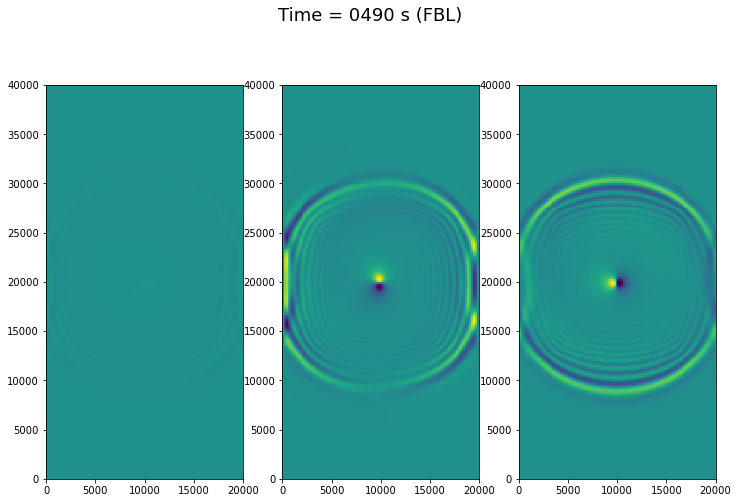

In [7]:
ghosts = [0,0,0,0] # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
    
h0 = np.ones(dataShape, dtype=np.float32) * 60
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32)
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32)
    
#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

#Initialize simulator
fbl_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0}
sim = FBL.FBL(**fbl_args, **sim_args)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)

Plotting static figure
..................................................

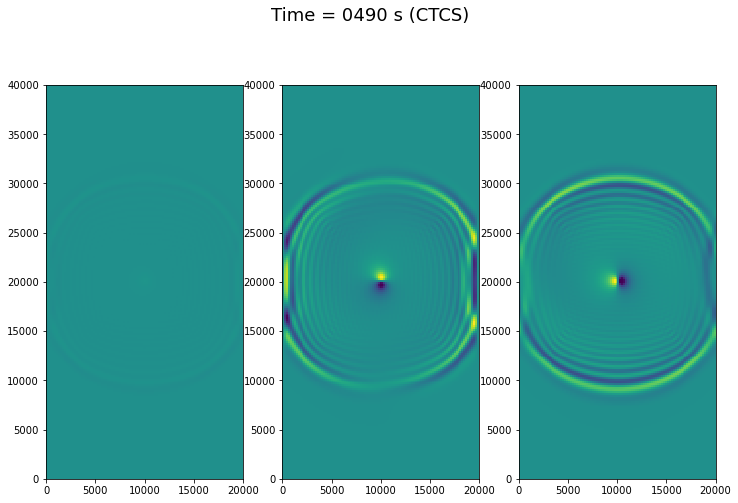

In [8]:
ghosts = [1,1,1,1] # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

h0 = np.ones(dataShape, dtype=np.float32) * 60.0;
eta0 = np.zeros(dataShape, dtype=np.float32);
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);       

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

#Initialize simulator
ctcs_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0, "A": 1.0}
sim = CTCS.CTCS(**ctcs_args, **sim_args)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)

Plotting static figure
..................................................

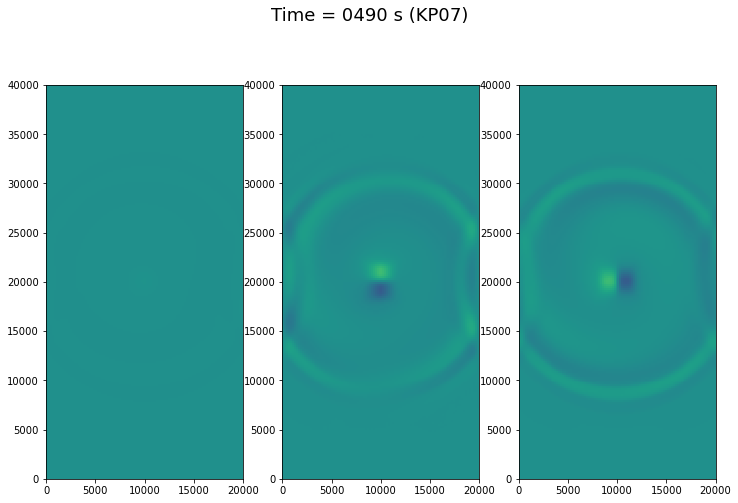

In [9]:
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

#Initialize simulator
ctcs_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "use_rk2": True}
sim = KP07.KP07(**ctcs_args, **sim_args)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)

Using latitude to create Coriolis f texture (104.000000x204.000000 cells)
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


Plotting static figure
..................................................

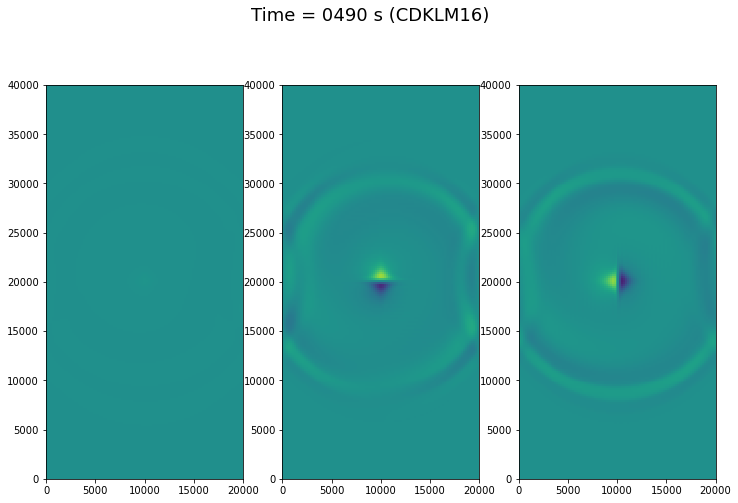

In [10]:
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

#Initialize simulator
ctcs_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2}
sim = CDKLM16.CDKLM16(**ctcs_args, **sim_args)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)